In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("/kaggle/input/spam-emails/spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
def plot_class_distribution(dataframe):
    data = {}
    for category in dataframe['Category'].value_counts().index:
        data[category] = dataframe['Category'].value_counts()[category]

    print(data)
    
    classes = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (5, 2))

    plt.bar(classes, values)

    plt.xlabel("Classes")
    plt.ylabel("No. of samples")
    plt.title("Class distribution")
    plt.show()

{'ham': 4825, 'spam': 747}


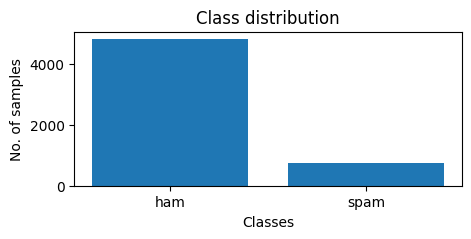

In [4]:
plot_class_distribution(df)

In [5]:
spam_df = df[df['Category']=='spam']
spam_df.shape

(747, 2)

In [6]:
ham_df = df[df['Category']=='ham']
ham_df.shape

(4825, 2)

In [7]:
ham_df_downsampled = ham_df.sample(spam_df.shape[0])
ham_df_downsampled.shape

(747, 2)

In [8]:
balanced_df = pd.concat([ham_df_downsampled, spam_df])
balanced_df.shape

(1494, 2)

{'ham': 747, 'spam': 747}


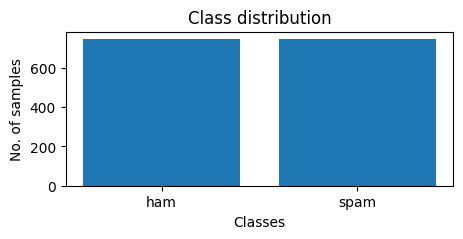

In [9]:
plot_class_distribution(balanced_df)

In [10]:
balanced_df['spam']= balanced_df['Category'].apply(lambda x: 1 if x=='spam' else 0)
balanced_df.sample(5)

,Category,Message,spam
892,ham,I am great princess! What are you thinking abo...,0
1874,spam,You have WON a guaranteed £1000 cash or a £200...,1
4436,spam,Don't b floppy... b snappy & happy! Only gay c...,1
3420,spam,Do you want a new Video phone? 600 anytime any...,1
3129,ham,would u fuckin believe it they didnt know i ha...,0


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
X_train, X_test, y_train, y_test = train_test_split(balanced_df['Message'], balanced_df['spam'], stratify=balanced_df['spam'])

In [13]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [22]:
collection = [
    {
        'preprocessor': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
        'encoder': 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',
    },
    {
        'preprocessor': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
        'encoder': 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4',
    },
    {
        'preprocessor': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
        'encoder': 'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/4',
    },
    {
        'preprocessor': 'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
        'encoder': 'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4',
    },
    {
        'preprocessor': 'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
        'encoder': 'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/4',
    },
    {
        'preprocessor': 'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
        'encoder': 'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/4',
    },
    {
        'preprocessor': 'https://tfhub.dev/tensorflow/bert_zh_preprocess/3',
        'encoder': 'https://tfhub.dev/tensorflow/bert_zh_L-12_H-768_A-12/4',
    },
    {
        'preprocessor': 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
        'encoder': 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4',
    },
]

In [15]:
def plot_cosine_similarities(preprocessor, encoder):
    
    def get_sentence_embeding(sentences):
        preprocessed_text = preprocessor(sentences)
        return encoder(preprocessed_text)['pooled_output']
    
    e = get_sentence_embeding([
        "banana", "grapes",
        "mango", "jalal uddin",
        "elon musk", "bill gates"
    ])

    print(cosine_similarity([e[0]],[e[1]]))
    print(cosine_similarity([e[2]],[e[3]]))
    print(cosine_similarity([e[4]],[e[5]]))

In [16]:
def generate_model(preprocessor, encoder):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = preprocessor(text_input)
    outputs = encoder(preprocessed_text)

    l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
    l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

    model = tf.keras.Model(inputs=[text_input], outputs = [l])
    
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
    ])
    
    return model
    

In [17]:
def train_model(model):
    model.fit(X_train, y_train, epochs=10)

In [18]:
def plot_cm(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [25]:
def evaluate_model(model):
    evaluations = model.evaluate(X_test, y_test)
    
    y_predicted = model.predict(X_test)
    y_predicted = y_predicted.flatten()
    y_predicted = np.where(y_predicted > 0.5, 1, 0)
    
    plot_cm(y_test, y_predicted)
    
    return evaluations

Encoder:  <tensorflow_hub.keras_layer.KerasLayer object at 0x7e8eec1a30a0>
Cosine Similarity of Embedding:
[[0.9911089]]
[[0.54767233]]
[[0.9164159]]
Model Generation:
Epoch 1/10
35/35 [==============================] - 15s 214ms/step - loss: 0.6711 - accuracy: 0.6062 - precision: 0.6046 - recall: 0.6143
Epoch 2/10
35/35 [==============================] - 8s 224ms/step - loss: 0.5326 - accuracy: 0.7804 - precision: 0.7754 - recall: 0.7893
Epoch 3/10
35/35 [==============================] - 7s 213ms/step - loss: 0.4542 - accuracy: 0.8393 - precision: 0.8310 - recall: 0.8518
Epoch 4/10
35/35 [==============================] - 7s 214ms/step - loss: 0.3984 - accuracy: 0.8696 - precision: 0.8485 - recall: 0.9000
Epoch 5/10
35/35 [==============================] - 7s 214ms/step - loss: 0.3664 - accuracy: 0.8759 - precision: 0.8611 - recall: 0.8964
Epoch 6/10
35/35 [==============================] - 8s 225ms/step - loss: 0.3461 - accuracy: 0.8732 - precision: 0.8591 - recall: 0.8929
Epoch 7/1

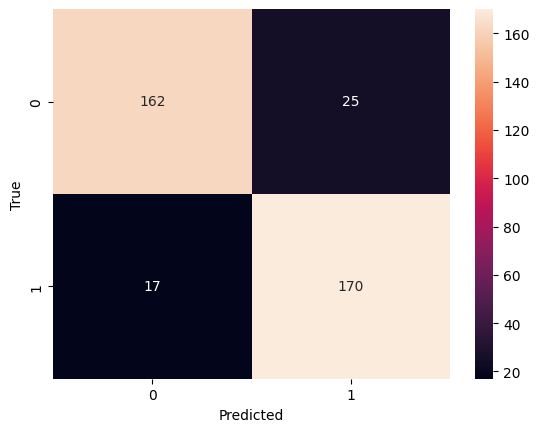

Encoder:  <tensorflow_hub.keras_layer.KerasLayer object at 0x7e8ec6481660>
Cosine Similarity of Embedding:
[[0.9605022]]
[[0.9179197]]
[[0.9961144]]
Model Generation:
Epoch 1/10
35/35 [==============================] - 33s 544ms/step - loss: 0.6952 - accuracy: 0.5661 - precision: 0.5623 - recall: 0.5964
Epoch 2/10
35/35 [==============================] - 19s 551ms/step - loss: 0.5426 - accuracy: 0.7304 - precision: 0.7240 - recall: 0.7446
Epoch 3/10
35/35 [==============================] - 19s 547ms/step - loss: 0.5127 - accuracy: 0.7643 - precision: 0.7569 - recall: 0.7786
Epoch 4/10
35/35 [==============================] - 19s 550ms/step - loss: 0.5040 - accuracy: 0.7563 - precision: 0.7504 - recall: 0.7679
Epoch 5/10
35/35 [==============================] - 19s 551ms/step - loss: 0.4744 - accuracy: 0.7759 - precision: 0.7588 - recall: 0.8089
Epoch 6/10
35/35 [==============================] - 19s 546ms/step - loss: 0.4629 - accuracy: 0.8018 - precision: 0.7761 - recall: 0.8482
Epoch

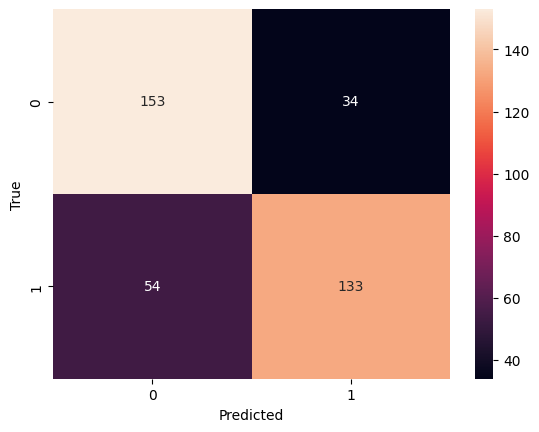

Encoder:  <tensorflow_hub.keras_layer.KerasLayer object at 0x7e930052f850>
Cosine Similarity of Embedding:
[[0.9462911]]
[[0.9214739]]
[[0.92357767]]
Model Generation:
Epoch 1/10
35/35 [==============================] - 33s 549ms/step - loss: 0.6461 - accuracy: 0.6491 - precision: 0.6510 - recall: 0.6429
Epoch 2/10
35/35 [==============================] - 19s 551ms/step - loss: 0.5243 - accuracy: 0.7875 - precision: 0.7981 - recall: 0.7696
Epoch 3/10
35/35 [==============================] - 19s 545ms/step - loss: 0.4454 - accuracy: 0.8500 - precision: 0.8698 - recall: 0.8232
Epoch 4/10
35/35 [==============================] - 19s 547ms/step - loss: 0.3972 - accuracy: 0.8500 - precision: 0.8657 - recall: 0.8286
Epoch 5/10
35/35 [==============================] - 19s 547ms/step - loss: 0.3726 - accuracy: 0.8562 - precision: 0.8874 - recall: 0.8161
Epoch 6/10
35/35 [==============================] - 19s 549ms/step - loss: 0.3413 - accuracy: 0.8857 - precision: 0.8956 - recall: 0.8732
Epoc

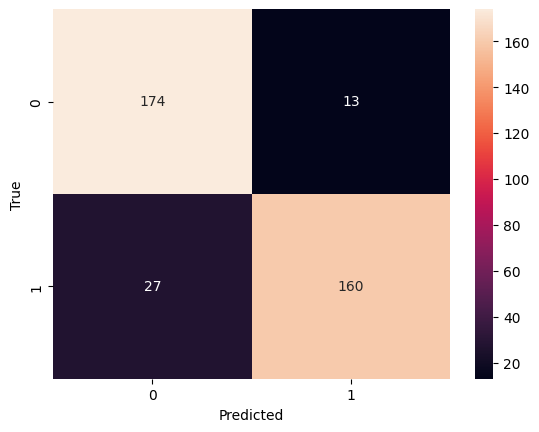

Encoder:  <tensorflow_hub.keras_layer.KerasLayer object at 0x7e8ef4797790>
Cosine Similarity of Embedding:
[[0.9939486]]
[[0.9790652]]
[[0.9872453]]
Model Generation:
Epoch 1/10
35/35 [==============================] - 15s 215ms/step - loss: 0.6693 - accuracy: 0.5884 - precision: 0.5929 - recall: 0.5643
Epoch 2/10
35/35 [==============================] - 8s 222ms/step - loss: 0.5940 - accuracy: 0.7134 - precision: 0.7193 - recall: 0.7000
Epoch 3/10
35/35 [==============================] - 8s 214ms/step - loss: 0.5434 - accuracy: 0.7536 - precision: 0.7465 - recall: 0.7679
Epoch 4/10
35/35 [==============================] - 8s 214ms/step - loss: 0.4958 - accuracy: 0.8009 - precision: 0.7951 - recall: 0.8107
Epoch 5/10
35/35 [==============================] - 8s 215ms/step - loss: 0.4568 - accuracy: 0.8500 - precision: 0.8256 - recall: 0.8875
Epoch 6/10
35/35 [==============================] - 8s 224ms/step - loss: 0.4301 - accuracy: 0.8438 - precision: 0.8302 - recall: 0.8643
Epoch 7/10

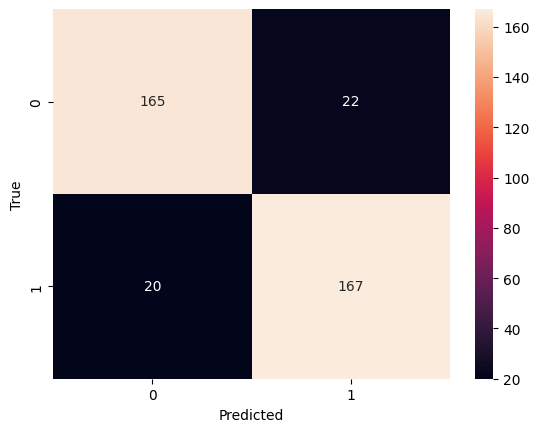

Encoder:  <tensorflow_hub.keras_layer.KerasLayer object at 0x7e8eb61234f0>
Cosine Similarity of Embedding:
[[0.43881303]]
[[0.84462845]]
[[0.9714371]]
Model Generation:
Epoch 1/10
35/35 [==============================] - 34s 544ms/step - loss: 0.6945 - accuracy: 0.5875 - precision: 0.5811 - recall: 0.6268
Epoch 2/10
35/35 [==============================] - 19s 551ms/step - loss: 0.6015 - accuracy: 0.6804 - precision: 0.6753 - recall: 0.6946
Epoch 3/10
35/35 [==============================] - 19s 550ms/step - loss: 0.5632 - accuracy: 0.6982 - precision: 0.6961 - recall: 0.7036
Epoch 4/10
35/35 [==============================] - 19s 543ms/step - loss: 0.5304 - accuracy: 0.7509 - precision: 0.7330 - recall: 0.7893
Epoch 5/10
35/35 [==============================] - 19s 548ms/step - loss: 0.5000 - accuracy: 0.7723 - precision: 0.7572 - recall: 0.8018
Epoch 6/10
35/35 [==============================] - 19s 543ms/step - loss: 0.4673 - accuracy: 0.8143 - precision: 0.7953 - recall: 0.8464
Epo

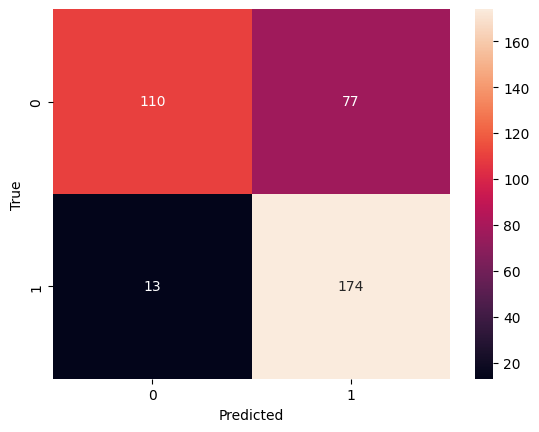

Encoder:  <tensorflow_hub.keras_layer.KerasLayer object at 0x7e8ebeb87220>
Cosine Similarity of Embedding:
[[0.88046515]]
[[0.9717768]]
[[0.9428725]]
Model Generation:
Epoch 1/10
35/35 [==============================] - 33s 551ms/step - loss: 0.7125 - accuracy: 0.5375 - precision: 0.5362 - recall: 0.5554
Epoch 2/10
35/35 [==============================] - 19s 543ms/step - loss: 0.5583 - accuracy: 0.7223 - precision: 0.7235 - recall: 0.7196
Epoch 3/10
35/35 [==============================] - 19s 550ms/step - loss: 0.5032 - accuracy: 0.7732 - precision: 0.7802 - recall: 0.7607
Epoch 4/10
35/35 [==============================] - 19s 550ms/step - loss: 0.4658 - accuracy: 0.7929 - precision: 0.7971 - recall: 0.7857
Epoch 5/10
35/35 [==============================] - 19s 543ms/step - loss: 0.4337 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125
Epoch 6/10
35/35 [==============================] - 19s 549ms/step - loss: 0.4096 - accuracy: 0.8348 - precision: 0.8453 - recall: 0.8196
Epoc

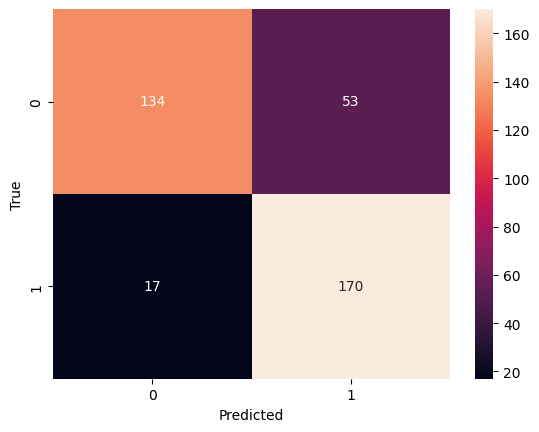

Encoder:  <tensorflow_hub.keras_layer.KerasLayer object at 0x7e8ebcc351b0>
Cosine Similarity of Embedding:
[[0.9334147]]
[[0.85587656]]
[[0.9690889]]
Model Generation:
Epoch 1/10
35/35 [==============================] - 15s 213ms/step - loss: 0.5792 - accuracy: 0.6982 - precision: 0.6982 - recall: 0.6982
Epoch 2/10
35/35 [==============================] - 8s 221ms/step - loss: 0.4393 - accuracy: 0.8321 - precision: 0.8185 - recall: 0.8536
Epoch 3/10
35/35 [==============================] - 8s 215ms/step - loss: 0.3788 - accuracy: 0.8571 - precision: 0.8597 - recall: 0.8536
Epoch 4/10
35/35 [==============================] - 7s 214ms/step - loss: 0.3242 - accuracy: 0.8875 - precision: 0.8889 - recall: 0.8857
Epoch 5/10
35/35 [==============================] - 8s 215ms/step - loss: 0.2929 - accuracy: 0.9071 - precision: 0.9145 - recall: 0.8982
Epoch 6/10
35/35 [==============================] - 7s 213ms/step - loss: 0.2706 - accuracy: 0.9161 - precision: 0.9206 - recall: 0.9107
Epoch 7/1

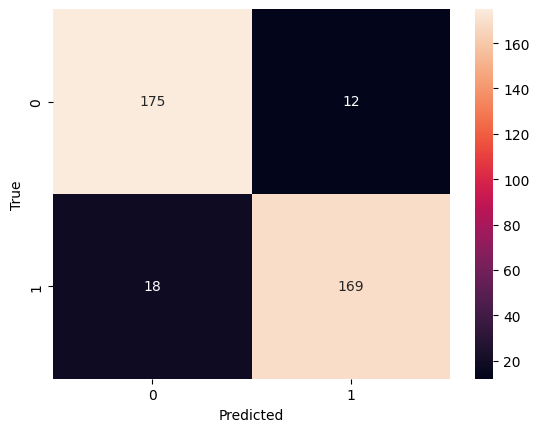

Encoder:  <tensorflow_hub.keras_layer.KerasLayer object at 0x7e93804b86d0>
Cosine Similarity of Embedding:
[[0.85789865]]
[[0.861336]]
[[0.85264885]]
Model Generation:
Epoch 1/10
35/35 [==============================] - 18s 215ms/step - loss: 0.6229 - accuracy: 0.7152 - precision: 0.7269 - recall: 0.6893
Epoch 2/10
35/35 [==============================] - 7s 213ms/step - loss: 0.5376 - accuracy: 0.8482 - precision: 0.8328 - recall: 0.8714
Epoch 3/10
35/35 [==============================] - 8s 224ms/step - loss: 0.4715 - accuracy: 0.9143 - precision: 0.9249 - recall: 0.9018
Epoch 4/10
35/35 [==============================] - 8s 214ms/step - loss: 0.4164 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304
Epoch 5/10
35/35 [==============================] - 7s 213ms/step - loss: 0.3788 - accuracy: 0.9366 - precision: 0.9421 - recall: 0.9304
Epoch 6/10
35/35 [==============================] - 7s 214ms/step - loss: 0.3452 - accuracy: 0.9330 - precision: 0.9354 - recall: 0.9304
Epoch 7/1

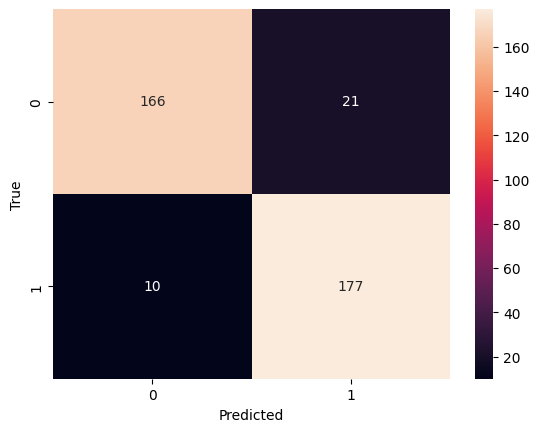

In [26]:
table = []
for item in collection:
    bert_preprocess = hub.KerasLayer(item['preprocessor'])
    bert_encoder = hub.KerasLayer(item['encoder'])
    
    print("Encoder: ", bert_encoder)
    print("Cosine Similarity of Embedding:")
    plot_cosine_similarities(bert_preprocess, bert_encoder)
    
    print("Model Generation:")
    model = generate_model(bert_preprocess, bert_encoder)
    train_model(model)
    
    evaluations = evaluate_model(model)
    table.append({
        'loss': evaluations[0],
        'accuracy': evaluations[1],
        'precision': evaluations[2],
        'recall': evaluations[3],
    })

In [33]:
for i, item in enumerate(collection):
    model_name = item['encoder'].split('/')[4]
    table[i]['model'] = model_name

In [39]:
pd.options.display.float_format = '{:.2%}'.format
evdf = pd.DataFrame(table)
evdf = evdf.reindex(columns=['model','loss', 'accuracy', 'precision', 'recall'])

In [40]:
evdf

,model,loss,accuracy,precision,recall
0,bert_en_uncased_L-12_H-768_A-12,29.22%,88.77%,87.18%,90.91%
1,bert_en_uncased_L-24_H-1024_A-16,50.59%,76.47%,79.64%,71.12%
2,bert_en_wwm_uncased_L-24_H-1024_A-16,28.88%,89.30%,92.49%,85.56%
3,bert_en_cased_L-12_H-768_A-12,36.53%,88.77%,88.36%,89.30%
4,bert_en_cased_L-24_H-1024_A-16,45.54%,75.94%,69.32%,93.05%
5,bert_en_wwm_cased_L-24_H-1024_A-16,40.65%,81.28%,76.23%,90.91%
6,bert_zh_L-12_H-768_A-12,24.51%,91.98%,93.37%,90.37%
7,bert_multi_cased_L-12_H-768_A-12,28.75%,91.71%,89.39%,94.65%


In [42]:
evdf.to_csv('res.csv')